# Early functions with better experiments

We package some of the functions used previously for better experimentation.

### Dependencies and initialize

Note that we now rely on kedro to make life a bit easier.

In [ ]:
%load_ext kedro.ipython
%reload_kedro
%load_ext autoreload
%autoreload 2
%config IPCompleter.use_jedi=False
from IPython.core.interactiveshell import InteractiveShell
import os
import pandas as pd
import numpy as np
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import matplotlib.pyplot as plt
from pathlib import Path

InteractiveShell.ast_node_interactivity = "all"
os.chdir(context.project_path)
catalog = context.catalog
params = context.params

First, we cache models and load from cache if they are available:

In [ ]:
def load_cached_model(
    model_name: str,
    cache_dir: str = "data/06_models/.cache",
    force_download: bool = False,
) -> tuple:
    """
    Load model from cache if it exists, otherwise download and cache it.

    Args:
        model_name: HuggingFace model identifier
        cache_dir: Directory for model caching
        force_download: Force fresh download even if cached

    Returns:
        tuple: (model, tokenizer)
    """
    cache_path = Path(cache_dir)
    model_cache = cache_path / model_name.split("/")[-1]

    # Create cache directory
    cache_path.mkdir(parents=True, exist_ok=True)

    try:
        if model_cache.exists() and not force_download:
            print(f"Loading model from cache: {model_cache}")
            tokenizer = AutoTokenizer.from_pretrained(
                model_cache, local_files_only=True
            )
            model = AutoModelForCausalLM.from_pretrained(
                model_cache,
                local_files_only=True,
                # device_map="auto"
            )
        else:
            print(f"Downloading model {model_name} to {model_cache}")
            # Download and cache tokenizer
            tokenizer = AutoTokenizer.from_pretrained(model_name)
            tokenizer.save_pretrained(model_cache)

            # Download and cache model
            model = AutoModelForCausalLM.from_pretrained(
                model_name,
                # device_map="auto"
            )
            model.save_pretrained(model_cache)

        # Set padding token if needed
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token

        return model, tokenizer

    except Exception as e:
        print(f"Error loading model: {str(e)}")
        raise

In [ ]:
model, tokenizer = load_cached_model("microsoft/phi-2")

Next we get the input tokens, based on the input string and model:

In [ ]:
def gen_token_input(
    input_text,
    tokenizer,
    return_tensors="pt",
    padding=True,
    truncation=True,
    return_attention_mask=True,
):
    input_ids = tokenizer(
        input_text,
        return_tensors=return_tensors,
        padding=padding,
        truncation=truncation,
        return_attention_mask=return_attention_mask,
    ).input_ids
    return input_ids


input_tests = [
    "The capital of France is",
    "The capital of South Africa is",
    "The capital of Singapore is",
]
for text in input_tests:
    print(gen_token_input(text, tokenizer))

This just shows the different tokens assigned to the country names.

We still then manually set the hyper-parameters. For more formal experiments, these can be set using yaml and then numerated during experiments:

In [ ]:
hyper_params = {
    "max_new_tokens": 20,
    "do_sample": True,
    "temperature": 0.7,
    "top_p": 0.9,
    "top_k": 50,
    "repetition_penalty": 1.2,
    "no_repeat_ngram_size": 2,
    "return_dict_in_generate": True,
    "output_scores": True,
    "num_return_sequences": 1,
    "pad_token_id": tokenizer.pad_token_id,
}

And the function to generate the output:

In [99]:
def gen_output(input_ids, model, seed, **hyper_params):
    if seed is not None:
        torch.manual_seed(seed)
    with torch.no_grad():
        outputs = model.generate(input_ids, **hyper_params)
    return outputs

In [9]:
input_tokens = gen_token_input("The capital of France is", tokenizer)
outputs = gen_output(input_tokens, model, 42, **hyper_params)

We can get back the tokens and their scores

In [ ]:
def analyze_generation_step(
    step: int,
    input_text: str,
    generated_token: int,
    top_probs: torch.Tensor,
    top_indices: torch.Tensor,
    tokenizer,
) -> list[dict]:
    """
    Analyze a single generation step and return candidate tokens with probabilities.
    """
    results = []

    # Get probabilities and tokens (stay in PyTorch)
    probs = top_probs[0].tolist()  # Convert to Python list
    token_ids = top_indices[0].tolist()  # Convert to Python list

    # Create result entry for each candidate token
    for prob, token_id in zip(probs, token_ids):
        token_text = tokenizer.decode([token_id])
        is_chosen = token_id == generated_token
        log_prob = np.log(prob) if prob > 0 else float("-inf")

        result = {
            "step": step,
            "input_text_chain": input_text,
            "candidate_output_token": int(token_id),
            "candidate_output_text": token_text,
            "chosen": bool(is_chosen),
            "select_prob": float(prob),
            "select_logprob": float(log_prob),
        }
        results.append(result)

    return results

In [ ]:
def store_generation_results(
    outputs, input_ids: torch.Tensor, tokenizer, top_k: int = 5
) -> list[dict]:
    """
    Store complete generation results with token probabilities.
    """
    all_results = []
    generated_tokens = outputs.sequences[0, input_ids.shape[-1] :]
    scores = torch.stack(outputs.scores)

    # Calculate probabilities for each step
    probs = torch.softmax(scores, dim=-1)
    top_probs, top_indices = torch.topk(probs, k=top_k, dim=-1)

    # Build input text chain
    input_text = tokenizer.decode(input_ids[0])

    # Process each generation step
    for step, (token, step_probs, step_indices) in enumerate(
        zip(generated_tokens, top_probs, top_indices)
    ):
        # Add new results
        step_results = analyze_generation_step(
            step=step,
            input_text=input_text,
            generated_token=token.item(),
            top_probs=step_probs,
            top_indices=step_indices,
            tokenizer=tokenizer,
        )
        all_results.extend(step_results)

        # Update input chain for next step
        input_text += tokenizer.decode([token])

    return all_results

In [12]:
prob_results = store_generation_results(outputs, input_tokens, tokenizer, top_k=100)

In [13]:
prob_results_df = pd.DataFrame(prob_results)

In [14]:
prob_results_df.query("select_prob > 0 or chosen == True")

,step,input_text_chain,candidate_output_token,candidate_output_text,chosen,select_prob,select_logprob
0,0,The capital of France is,6342,Paris,True,1.000000,0.000000
100,1,The capital of France is Paris,13,.,True,0.637187,-0.450692
101,1,The capital of France is Paris,526,".""",False,0.318629,-1.143727
102,1,The capital of France is Paris,11,",",False,0.044184,-3.119397
200,2,The capital of France is Paris.,198,\n,True,1.000000,0.000000
300,3,The capital of France is Paris.\n,50256,<|endoftext|>,False,0.594023,-0.520838
301,3,The capital of France is Paris.\n,50284,,False,0.217037,-1.527687
302,3,The capital of France is Paris.\n,26410,Output,True,0.098689,-2.315785
303,3,The capital of France is Paris.\n,33706,Answer,False,0.051640,-2.963461
304,3,The capital of France is Paris.\n,2235,##,False,0.038612,-3.254195


And a final plot:

In [123]:
def plot_token_probabilities_horizontal(
    df, title="Token Probabilities by Generation Step"
):
    """Create horizontal bar plot with dynamic subplot heights."""
    steps = df["step"].unique()

    # Fixed bar parameters
    bar_height = 0.6
    bar_padding = 0.5  # Padding above and below bars

    # Calculate heights for each subplot based on number of bars
    step_sizes = df.groupby("step").size()
    subplot_heights = [size * (bar_height + bar_padding) for size in step_sizes]
    total_height = sum(subplot_heights)

    # Create figure with height ratios based on number of bars
    fig, axes = plt.subplots(
        len(steps),
        1,
        figsize=(10, total_height),
        gridspec_kw={"height_ratios": subplot_heights},
        squeeze=False,
    )

    bar_colors = {
        True: "#8B0000",  # Red for chosen tokens
        False: "#e0e0e0",  # Light grey for others
    }

    text_chains = {}
    current_text = df["input_text_chain"].iloc[0].split(" [")[0]  # Get initial in

    for idx, step in enumerate(steps):
        text_chains[step] = current_text
        step_chosen = df[(df["step"] == step) & (df["chosen"])][
            "candidate_output_text"
        ].iloc[0]
        current_text += step_chosen
        ax = axes[idx, 0]
        step_data = df[df["step"] == step].sort_values("select_prob", ascending=True)
        num_bars = len(step_data)

        # Create bars
        bars = ax.barh(
            range(num_bars),
            step_data["select_prob"],
            color=[bar_colors[c] for c in step_data["chosen"]],
            height=bar_height,
        )

        # Add value labels
        for bar in bars:
            width = bar.get_width()
            if width > 0.3:
                ax.text(
                    width - 0.05,
                    bar.get_y() + bar_height / 2,
                    f"{width:.3f}",
                    ha="right",
                    va="center",
                    fontsize=8,
                    color="white",
                )
            else:
                ax.text(
                    width + 0.02,
                    bar.get_y() + bar_height / 2,
                    f"{width:.3f}",
                    ha="left",
                    va="center",
                    fontsize=8,
                    color="black",
                )

        # Set dynamic y-axis limits
        ax.set_ylim(-bar_padding, num_bars - 1 + bar_padding)
        ax.set_xlim(0, 1.1)
        ax.set_yticks(range(num_bars))
        ax.set_yticklabels(
            [repr(text) for text in step_data["candidate_output_text"]], fontsize=9
        )
        ax.set_title(
            f'Step {step}: "{text_chains[step] + step_chosen}"', pad=10, wrap=True, fontsize=8
        )
        ax.grid(True, axis="x", linestyle="--", alpha=0.3)

    plt.suptitle(title, y=1, fontsize=10)
    # fig.text(0.5, 0.02, "Probability", ha="center")
    plt.tight_layout()

    return fig


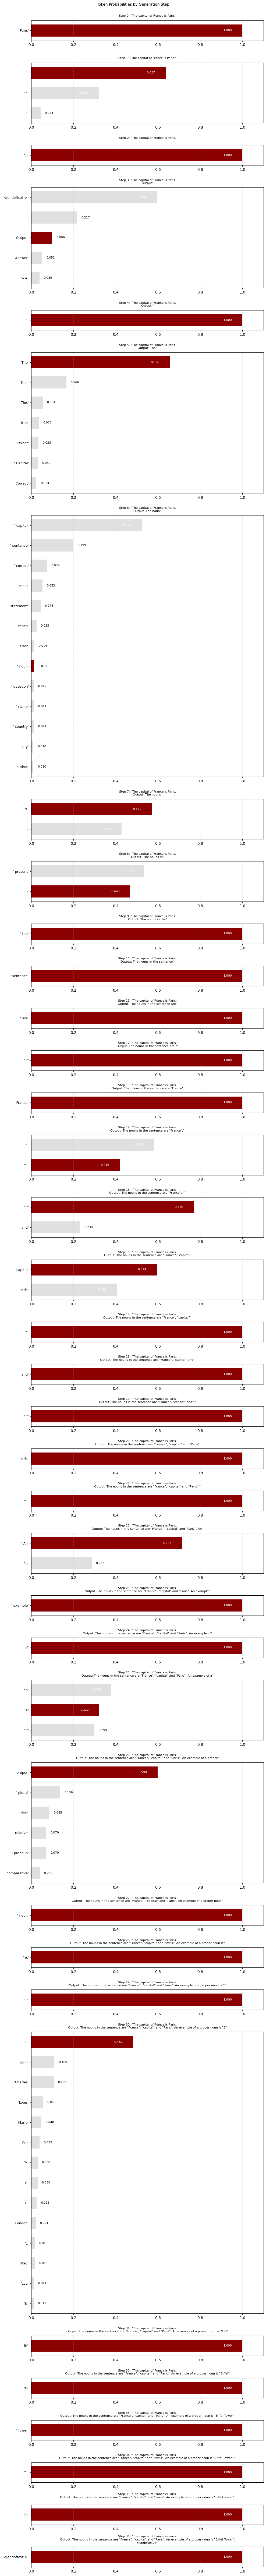

In [124]:
# Usage
filtered_df = prob_results_df.query("select_prob > 0 or chosen == True")
fig = plot_token_probabilities_horizontal(filtered_df)
plt.show()

This makes it a bit easier to analyze. Note that it stops quite suddenly due to the max token length setting. 

And all together now, with a longer max token:

Loading model from cache: data/06_models/.cache/phi-2


Loading checkpoint shards: 100%|██████████| 3/3 [00:02<00:00,  1.31it/s]


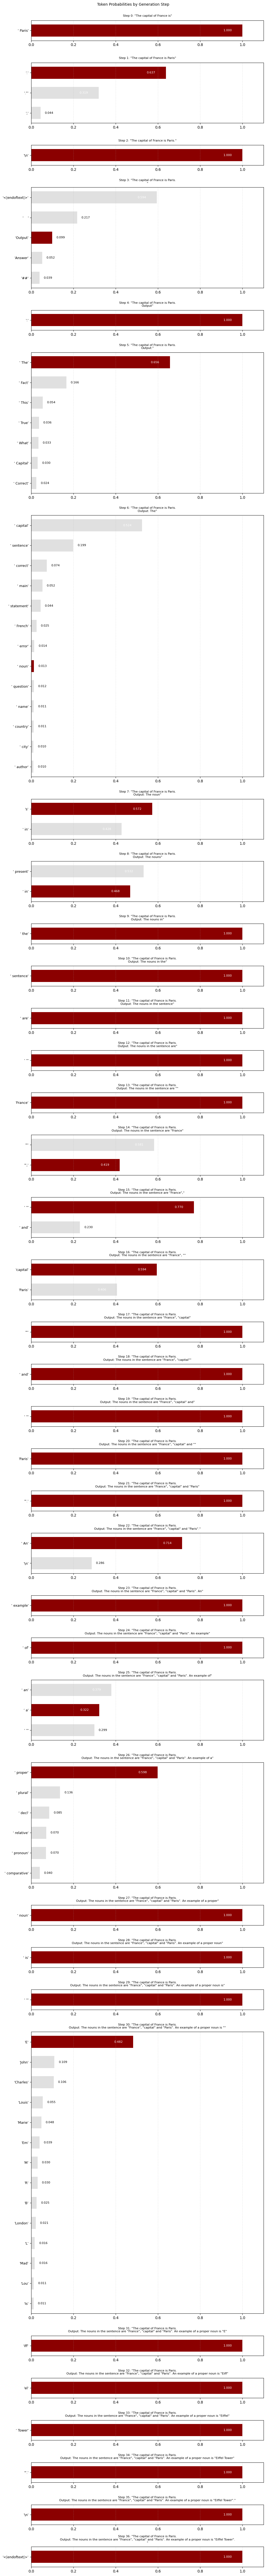

In [89]:
test_text = "The capital of France is"
model, tokenizer = load_cached_model("microsoft/phi-2")
hyper_params = {
    "max_new_tokens": 50,
    "do_sample": True,
    "temperature": 0.7,
    "top_p": 0.9,
    "top_k": 50,
    "repetition_penalty": 1.2,
    "no_repeat_ngram_size": 2,
    "return_dict_in_generate": True,
    "output_scores": True,
    "num_return_sequences": 1,
    "pad_token_id": tokenizer.pad_token_id,
}
input_tokens = gen_token_input(test_text, tokenizer)
outputs = gen_output(input_tokens, model, 42, **hyper_params)
prob_results = store_generation_results(outputs, input_tokens, tokenizer, top_k=100)
prob_results_df = pd.DataFrame(prob_results)
prob_results_analyse = prob_results_df.query("select_prob > 0 or chosen == True")
fig = plot_token_probabilities_horizontal(prob_results_analyse)
plt.show()

At least now we see the output until completion.

We repeat three times, using different seeds and max four output tokens:

In [110]:
def return_output(input_text, input_tokens, outputs, tokenizer):
    generated_tokens = outputs.sequences[0, input_tokens.shape[-1]:]
    return input_text + tokenizer.decode(generated_tokens)

test_text = "The capital of France is"
# model, tokenizer = load_cached_model("microsoft/phi-2")
hyper_params = {
    "max_new_tokens": 6,
    "do_sample": True,
    "temperature": 0.7,
    "top_p": 0.9,
    "top_k": 50,
    "repetition_penalty": 1.2,
    "no_repeat_ngram_size": 2,
    "return_dict_in_generate": True,
    "output_scores": True,
    "num_return_sequences": 1,
    "pad_token_id": tokenizer.pad_token_id,
}
input_tokens = gen_token_input(test_text, tokenizer)
outputs = gen_output(input_tokens, model, 42, **hyper_params) # we set the seed once:
print(return_output(test_text, input_tokens, outputs, tokenizer))
input_tokens = gen_token_input(test_text, tokenizer)
outputs = gen_output(input_tokens, model, None, **hyper_params)
print(return_output(test_text, input_tokens, outputs, tokenizer))
input_tokens = gen_token_input(test_text, tokenizer)
outputs = gen_output(input_tokens, model, None, **hyper_params)
print(return_output(test_text, input_tokens, outputs, tokenizer))

The capital of France is Paris.
Output: The
The capital of France is Paris.
<|endoftext|>
The capital of France is Paris.
    How many


We see slightly different outputs. Recall that we expect to see "<|endoftext|>" about 60% of the time. So easiest is just to repeat the experiment a bunch of times and count the frequency.

In [113]:
def last_token(outputs, tokenizer):
    last_token_id = outputs.sequences[0, -1].item()
    last_token = tokenizer.decode([last_token_id], skip_special_tokens=False)
    return last_token

def test_outputs(input_tokens, tokenizer, model, seed, hyper_params):
    outputs = gen_output(input_tokens, model, seed, **hyper_params)
    return last_token(outputs, tokenizer)

hyper_params = {
    "max_new_tokens": 2,
    "do_sample": True,
    "temperature": 0.7,
    "top_p": 0.9,
    "top_k": 50,
    "repetition_penalty": 1.2,
    "no_repeat_ngram_size": 2,
    "return_dict_in_generate": True,
    "output_scores": True,
    "num_return_sequences": 1,
    "pad_token_id": tokenizer.pad_token_id,
}
input_tokens = gen_token_input(test_text, tokenizer)
results = []
n_experiments = 100
for i in range(n_experiments):
    exp_result_i = test_outputs(input_tokens, tokenizer, model, i, hyper_params)
    results.append({"experiment": i, "last_token_text": exp_result_i, "seed": i})
    print(f"Experiment {i + 1} of {n_experiments} ({(i + 1) / n_experiments:.2f}): '{exp_result_i}'")
results_df = pd.DataFrame(results)
results_df["last_token_text"].value_counts()

Experiment 1 of 100 (0.01): 'r.'
Experiment 2 of 100 (0.02): 'r.'
Experiment 3 of 100 (0.03): 'r.'
Experiment 4 of 100 (0.04): 'r.'
Experiment 5 of 100 (0.05): 'r.'
Experiment 6 of 100 (0.06): 'r.'
Experiment 7 of 100 (0.07): 'r.'
Experiment 8 of 100 (0.08): 'r.'
Experiment 9 of 100 (0.09): 'r.'
Experiment 10 of 100 (0.10): 'r.'
Experiment 11 of 100 (0.11): 'r.'
Experiment 12 of 100 (0.12): 'r.'
Experiment 13 of 100 (0.13): 'r.'
Experiment 14 of 100 (0.14): 'r.'
Experiment 15 of 100 (0.15): 'r."'
Experiment 16 of 100 (0.16): 'r.'
Experiment 17 of 100 (0.17): 'r.'
Experiment 18 of 100 (0.18): 'r.'
Experiment 19 of 100 (0.19): 'r.'
Experiment 20 of 100 (0.20): 'r."'
Experiment 21 of 100 (0.21): 'r."'
Experiment 22 of 100 (0.22): 'r."'
Experiment 23 of 100 (0.23): 'r.'
Experiment 24 of 100 (0.24): 'r."'
Experiment 25 of 100 (0.25): 'r.'
Experiment 26 of 100 (0.26): 'r.'
Experiment 27 of 100 (0.27): 'r.'
Experiment 28 of 100 (0.28): 'r.'
Experiment 29 of 100 (0.29): 'r.'
Experiment 30 of 1


last_token_text
.     71
."    25
,      4
Name: count, dtype: int64

In [115]:
results_df["last_token_text"].value_counts()


last_token_text
.     71
."    25
,      4
Name: count, dtype: int64

This is consistent with the advertised probabilities of 0.637, 0.319 and 0.044 for those three characters. We can move to the sixth step, which should ideally be "<|endoftext|>", but that will be conditional on Step 2. We can filter accordingly, if we wish.